In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from tqdm import tqdm
import sys
sys.path.append('/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/image_analysis_code')
import image_functions as imfn
from segmentation import Segmentation


In [9]:
data_dir = '/fs/cbsuvlaminck2/workdir/bmg224/data/2021/devlaminck_widefield/2021_04_05_dnafishmethodchar'
re_glob = '*.czi'
sample_names = imfn.get_sample_names(data_dir=data_dir)
refl = ['gfp', 'cy5']
factors = ['method', 'plasmid', 'fov']

print(len(sample_names))

50


In [10]:
sys.path.append('/fs/cbsuvlaminck2/workdir/bmg224/hiprfish/utilities')
import useful_functions_imaging as ufi

In [11]:
keys = ufi.get_filename_keys(sample_names, factors)
len(keys
   )

50

In [32]:
import pandas as pd
output_dir = '../image_processing'
spot_int_filenames = [output_dir + '/' + sn + '_spot_seg_cell_id.csv' for sn in sample_names]
spot_int = [pd.read_csv(f) for f in spot_int_filenames]
print(len(spot_int))

50


In [33]:
cell_props_filenames = [output_dir + '/' + sn + '_cell_seg_props.csv' for sn in sample_names]
cell_props = [pd.read_csv(f) for f in cell_props_filenames]
print(len(cell_props))

50


In [88]:
# Get ROC dfs with background shifted intensities
threshold_bins = 200
threshs = np.linspace(0,1,threshold_bins)
roc_input_dfs = []
for si in spot_int:
    intensities = si.Intensity.values
    cell_ids = si.cell_id.values
    curve = [intensities[intensities > t].shape[0] for t in threshs]
    curve_shift = curve[:1] + curve[:-1]
    slopes = [y2-y1 for y1, y2 in zip(curve_shift, curve)]
    slope_min = np.min(slopes)
    thresh_min = np.max(threshs[np.array(slopes) == slope_min])
    
    freq, bin_edges = np.histogram(intensities, bins=threshold_bins)
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    shift = bin_centers[freq==np.max(freq)]
    
    print(shift, thresh_min)
    int_shift = intensities - thresh_min
    df = pd.DataFrame(list(zip(cell_ids, int_shift)), columns=['cell_id','Intensity'])
    roc_input_dfs.append(df)


[0.12315093] 0.12562814070351758
[0.15981151] 0.16080402010050251
[0.13174851] 0.135678391959799
[0.15899647] 0.16080402010050251
[0.13989292] 0.1407035175879397
[0.14696598] 0.15075376884422112
[0.23929433] 0.24120603015075376
[0.12585223] 0.1306532663316583
[0.14097623] 0.1407035175879397
[0.12905378] 0.1306532663316583
[0.12775165] 0.1306532663316583
[0.12143006] 0.12562814070351758
[0.11564071] 0.11557788944723618
[0.23108053] 0.23115577889447236
[0.14859773] 0.15075376884422112
[0.11879648] 0.12060301507537688
[0.16905544] 0.1708542713567839
[0.14209523] 0.1457286432160804
[0.11961321] 0.12060301507537688
[0.13280995] 0.135678391959799
[0.1387271] 0.1407035175879397
[0.13082776] 0.135678391959799
[0.22948211] 0.23115577889447236
[0.13568934] 0.1407035175879397
[0.15889376] 0.16080402010050251
[0.11983374] 0.12060301507537688
[0.12908118] 0.1306532663316583
[0.15246423] 0.15577889447236182
[0.13575285] 0.1407035175879397
[0.19037347] 0.19597989949748745
[0.13711052] 0.1407035175879

In [90]:
values_list = list(zip(roc_input_dfs, cell_props))
im_seg_dict = imfn.get_nested_dict(key_list=keys, values_list=values_list, groupby_key_indices=(0,1,2))
len(im_seg_dict['a']['neg']['1'])

1

In [91]:
import numpy as np
from sklearn.metrics import auc

# phages = ['f','g']
phages = ['a','b','c','d','f','g']

times = ['pos']
control = 'neg'

fovs = ['1','2','3']

threshold_bins = 200
roc_dict = {}
for phage in phages:
    print(phage)
    roc_dict[phage] = {}
    for time in times:
        props_list_neg = im_seg_dict[phage][control]
        props_list_pos = im_seg_dict[phage][time]
        cells_true_pos = 0
        cells_false_pos = 0
        intensities = []
        for fov in fovs:
#         for pn, pp in zip(props_list_neg, props_list_pos):
            props_neg = im_seg_dict[phage][control][fov][0]
            props_pos = im_seg_dict[phage][time][fov][0]
            cells_false_pos += props_neg[1][0].cell_id.unique().shape[0]
            cells_true_pos += props_pos[1][0].cell_id.unique().shape[0]
            intensities += props_neg[1][0].Intensity.tolist() + props_pos[1][0].Intensity.tolist()
#         print(cells_false_pos)
#         print(cells_true_pos)
        pos_count_list = []
        neg_count_list = []
        thresholds = np.linspace(np.min(intensities), np.max(intensities), threshold_bins)
        for t in thresholds:
            cells_neg = 0
            cells_pos = 0
            for fov in fovs:
                props_neg = im_seg_dict[phage][control][fov][0]
                props_pos = im_seg_dict[phage][time][fov][0]
#             for props_neg, props_pos in zip(props_list_neg, props_list_pos):
                cells_neg += props_neg[1][0].loc[props_neg[1][0].Intensity >= t, 'cell_id'].unique().shape[0]
                cells_pos += props_pos[1][0].loc[props_pos[1][0].Intensity >= t, 'cell_id'].unique().shape[0]
#             print('threshold: FPR, TPR',np.round(t,4),np.round(cells_neg/cells_false_pos,4), np.round(cells_pos/cells_true_pos, 4))
            neg_count_list.append(cells_neg)
            pos_count_list.append(cells_pos)

        FPR = np.array(neg_count_list)/cells_false_pos
        TPR = np.array(pos_count_list)/cells_true_pos
        AUC = auc(FPR, TPR)
        roc_dict[phage][time] = (FPR, TPR, AUC)
        
# print(len(roc_dict['a']['pos']))

a
b
c
d
f
g


/home/bmg224/miniconda3/envs/hiprfish_imaging/lib/python3.5/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


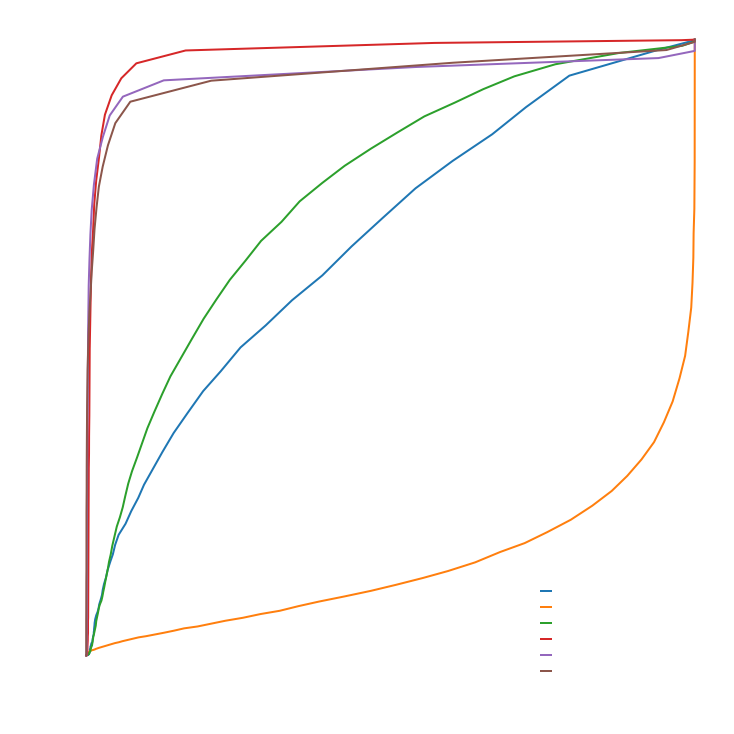

In [92]:
import matplotlib.pyplot as plt
# ft = 20

ft = 20
col = 'w'
dims = (10,10)

# ft = 7
# col = 'k'
# dims = (1.85, 1.85)

labels = ['HCR','Perm','Split','Denature','Passivate','Help']
# phages = ['f','g']
phages = ['a','b','c','d','f','g']

for time in times:
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={'pad': 0})    
    ax.patch.set_alpha(0)
    for phage, label in zip(phages, labels):
        fpr, tpr, AUC = roc_dict[phage][time]
        label = label + ', AUC=' + str(np.round(AUC,3))
        ax.plot(fpr, tpr, label=label, linewidth=2)
    ax.set_xlabel('FPR', fontsize=ft, color=col)
    ax.set_ylabel('TPR', fontsize=ft, color=col)
#     l = plt.legend(loc='lower right', markerscale=0.1, labelspacing=0.2)
    l = plt.legend(loc='lower right', fancybox=True, framealpha=0, markerscale=0.1, labelspacing=0.2,
                   handlelength=1)
    for text in l.get_texts():
        text.set_color(col)
        text.set_fontsize(ft*5//7)
    ax.spines['top'].set_color(col)
    ax.spines['bottom'].set_color(col)
    ax.spines['left'].set_color(col)
    ax.spines['right'].set_color(col)
    ax.tick_params(direction='in', color=col, labelcolor=col, labelsize=ft*5//7) 
    output_filename = '../figures/ROC_curves_new.pdf'
    plt.savefig(output_filename, transparent=True, dpi=300)
